## Linear v.s. Nonlinear dynamics

In [3]:
# packages
import torch
import pandas as pd
import pygsig.datasets.subduction
from pygsig.datasets.subduction import SubductionZone
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import importlib

In [4]:
# Download data
poly_path='datasets/subduction/polygon.geojson' # region of interest
rast_path='datasets/subduction/interface.grd' # interface data
data_path='datasets/subduction/data.geojson' # earthquake data
site_path='datasets/subduction/location.geojson' # site data
label_path='datasets/subduction/nonlinear.json'
start_date=pd.Timestamp('2008-01-01 11:59:00+0000', tz='UTC')
end_date=pd.Timestamp('2023-12-31 11:59:00+0000', tz='UTC')
dataset = SubductionZone(poly_path=poly_path,
                         rast_path=rast_path,
                         label_path=label_path,
                         data_path=data_path,
                         site_path=site_path,
                         start_date=start_date,
                         end_date=end_date,
                         redownload=False)

In [5]:
# Load data
seq_data = dataset.load_data(task_name='nonlinear',k=4)

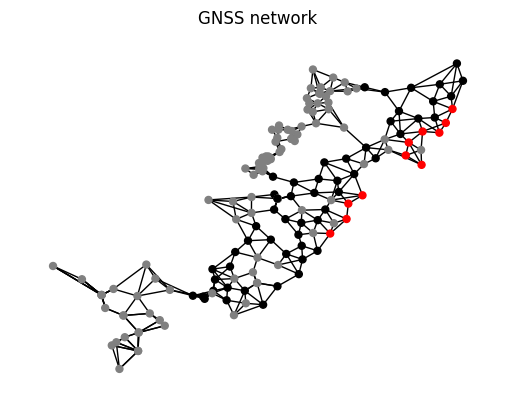

In [6]:
# Plot graph

G = nx.Graph()
G.add_nodes_from(range(seq_data.num_nodes))
G.add_edges_from(seq_data[0].edge_index.T.tolist())

pos = {node: position.numpy() for node, position in enumerate(seq_data[0].pos)}
depth = {node: measurement.item() for node, measurement in enumerate(seq_data[0].y)}
vector_depth = np.array([depth[i] for i in range(len(depth))])

# Define color map based on labels
color_map = {0: 'black', -1: 'grey', 1: 'red'}
node_colors = [color_map[depth[node]] for node in G.nodes]

plt.figure()
nx.draw_networkx_nodes(G, pos=pos, node_size=25, node_color=node_colors)
nx.draw_networkx_edges(G, pos=pos)
plt.title('GNSS network')
plt.axis('off')

plt.show()


Model: GCNClassification
Number of parameters: 5953


100%|██████████| 40/40 [00:28<00:00,  1.42it/s]

Accuracy: 0.8984 ± 0.0578, F1: 0.7048 ± 0.1772, Precision: 0.6438 ± 0.2314, Recall: 0.8542 ± 0.1488


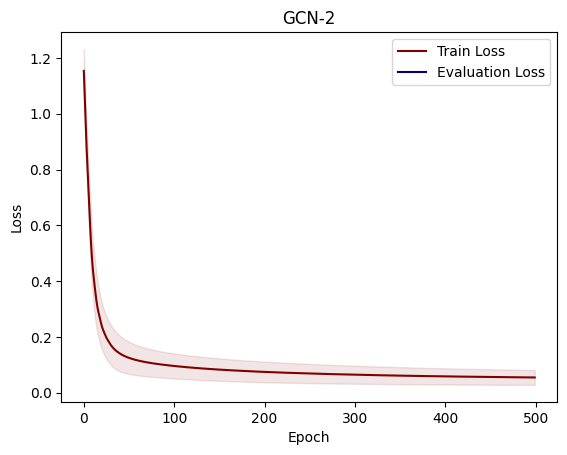

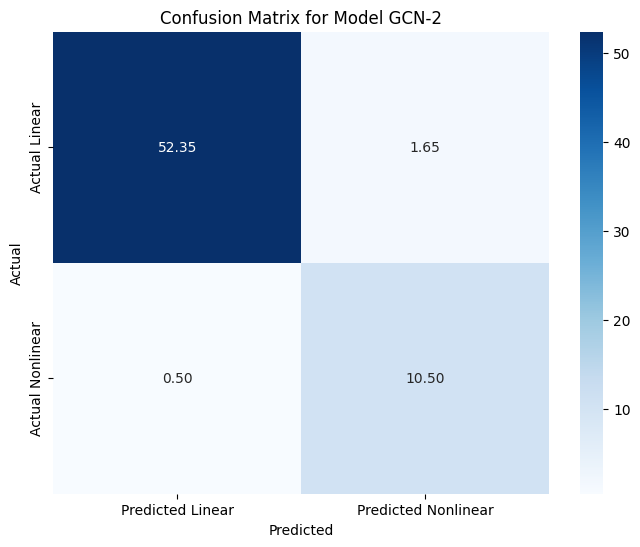

Model: GCNClassification
Number of parameters: 10113


100%|██████████| 40/40 [00:47<00:00,  1.18s/it]

Accuracy: 0.9242 ± 0.0715, F1: 0.8167 ± 0.1658, Precision: 0.7917 ± 0.1920, Recall: 0.8542 ± 0.1488


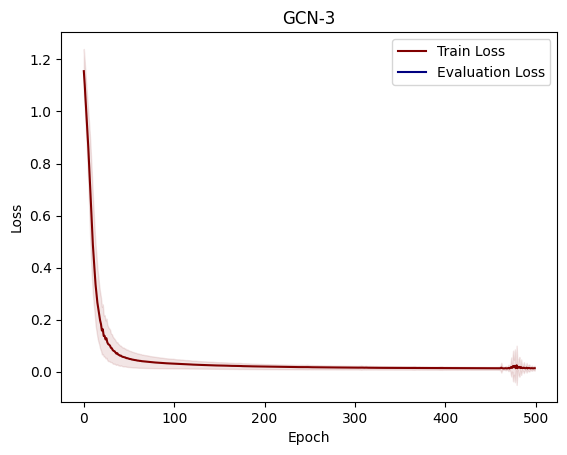

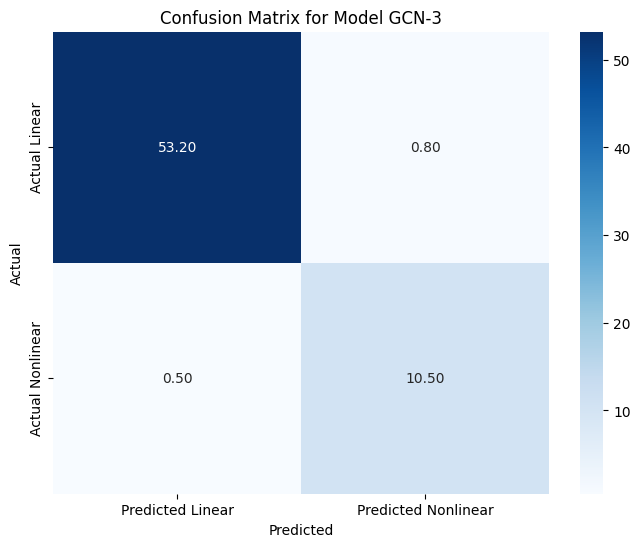

Model: GCNClassification
Number of parameters: 14273


100%|██████████| 40/40 [01:11<00:00,  1.78s/it]

Accuracy: 0.8832 ± 0.0897, F1: 0.7016 ± 0.1933, Precision: 0.6357 ± 0.2513, Recall: 0.8542 ± 0.1488


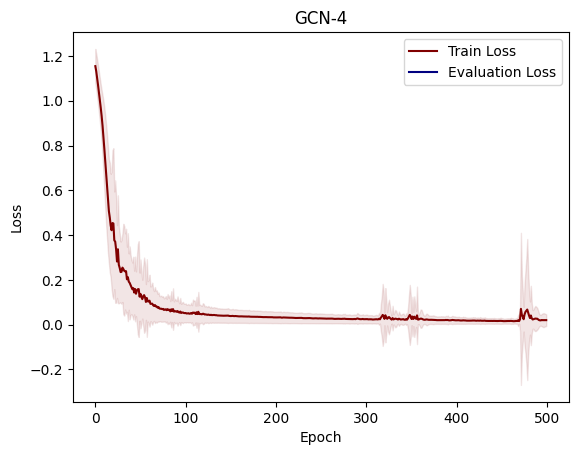

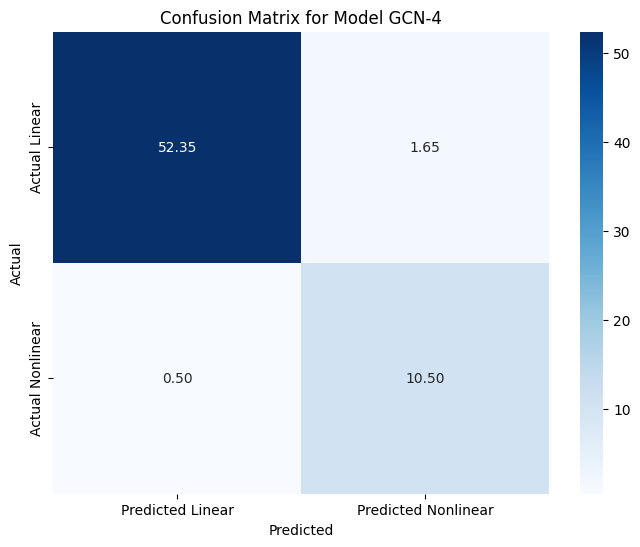

Model: GCNClassification
Number of parameters: 18433


100%|██████████| 40/40 [01:21<00:00,  2.05s/it]

Accuracy: 0.8858 ± 0.0991, F1: 0.7384 ± 0.1939, Precision: 0.6813 ± 0.2431, Recall: 0.8542 ± 0.1488


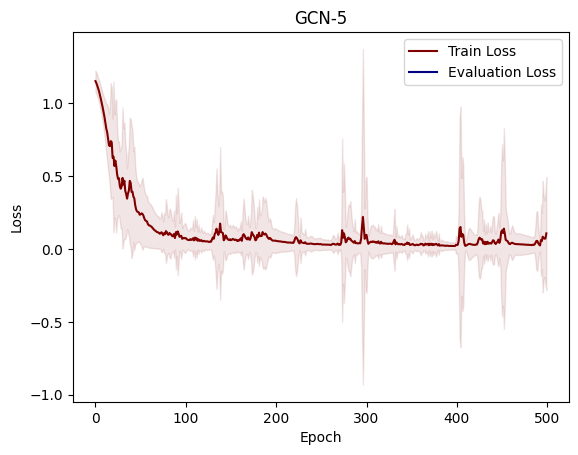

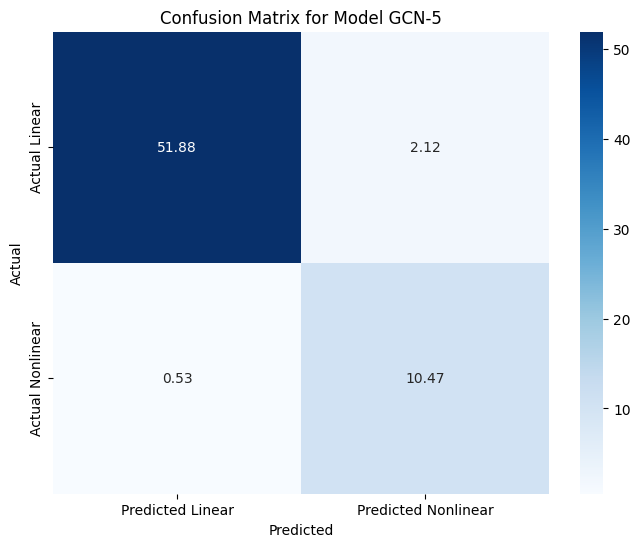

Model: MLPClassification
Number of parameters: 5953


100%|██████████| 40/40 [00:09<00:00,  4.06it/s]

Accuracy: 0.8416 ± 0.0986, F1: 0.5969 ± 0.2515, Precision: 0.5567 ± 0.2787, Recall: 0.7833 ± 0.2769


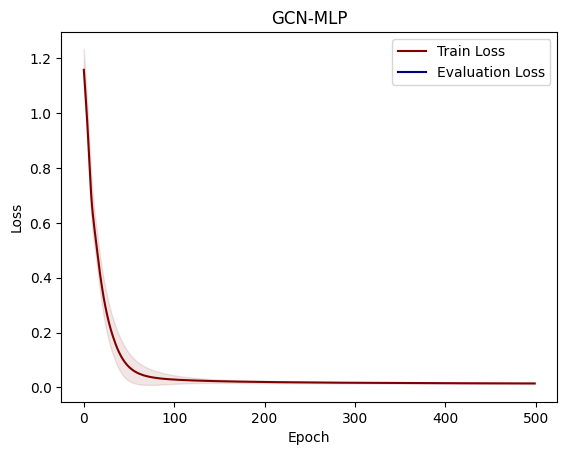

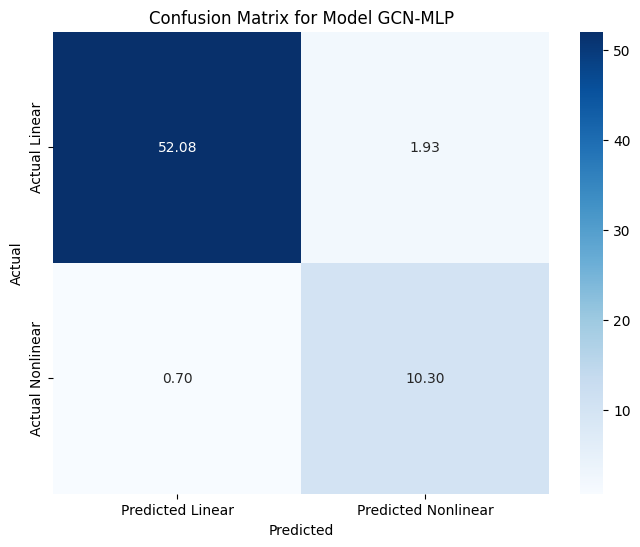

In [78]:
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
from sklearn.preprocessing import StandardScaler

# Import custom modules
import pygsig.graph 
import pygsig.models
import pygsig.signature
from pygsig.models import GCNClassification,MLPClassification
from pygsig.graph import split_nodes
from pygsig.signature import SignatureFeatures

import importlib
# Reload modules if needed
importlib.reload(pygsig.models)
importlib.reload(pygsig.signature)
importlib.reload(pygsig.graph)

# Set signature depth for the transformation
signature_depth = 3
signature_transform = SignatureFeatures(sig_depth=signature_depth, normalize=True, log_signature=True, time_augment=False, lead_lag=True)

# Apply signature transformation to the sequential data
data = signature_transform(seq_data)

# Set up parameters
num_nodes = data.num_nodes
num_splits = 4
num_trials = 10
num_epochs = 500
learning_rate = 5e-3
lasso = 1e-3
num_hidden = 64
print_during_training = False

# Create class weights for handling imbalance
positive_class_count = (data.y == 1).sum().item()
negative_class_count = (data.y == 0).sum().item()
class_weights = torch.tensor([negative_class_count / positive_class_count], dtype=torch.float)
# class_weights = torch.tensor([20.0], dtype=torch.float)

# Initialize models
models = []
models.append(GCNClassification(num_channels=[data.num_node_features, num_hidden, 1]))
models.append(GCNClassification(num_channels=[data.num_node_features, num_hidden, num_hidden, 1]))
models.append(GCNClassification(num_channels=[data.num_node_features, num_hidden, num_hidden, num_hidden, 1]))
models.append(GCNClassification(num_channels=[data.num_node_features, num_hidden, num_hidden, num_hidden, num_hidden, 1]))
models.append(MLPClassification(num_channels=[data.num_node_features, num_hidden, 1]))

model_names = [
                'GCN-2',
                'GCN-3',
                'GCN-4',
                'GCN-5',
                'GCN-MLP',
                ]

accuracy_models = []
predictions_models = []

# Create a mask for valid labels (ignoring -1)
label_mask = data.y != -1

# Criterion for binary classification with BCEWithLogitsLoss
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)

# Initialize arrays for metrics
accuracy_models = []
confusion_models = []

for model_number, model in enumerate(models):
    print(f'Model: {model._get_name()}')
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lasso)
    
    # Initialize arrays to store losses
    train_losses = np.zeros([num_splits, num_trials, num_epochs])
    eval_losses = np.zeros([num_splits, num_trials, num_epochs])
    
    accuracy = np.zeros([num_splits, num_trials])
    f1 = np.zeros([num_splits, num_trials])
    precision = np.zeros([num_splits, num_trials])
    recall = np.zeros([num_splits, num_trials])
    confusion_matrices = np.zeros([num_splits, num_trials, 2, 2])
    
    with tqdm(total=num_splits * num_trials, disable=print_during_training) as pbar:
        splits = split_nodes(num_nodes, num_splits, test_ratio=1.0, seed=30) # no validation
        
        for split in range(num_splits):
            train_indices, eval_indices, test_indices = splits[split]
            
            # Create masks for training, evaluation, and testing
            train_mask = torch.zeros(num_nodes, dtype=torch.bool)
            eval_mask = torch.zeros(num_nodes, dtype=torch.bool)
            test_mask = torch.zeros(num_nodes, dtype=torch.bool)
            
            train_mask[train_indices] = True
            eval_mask[eval_indices] = True
            test_mask[test_indices] = True
            
            # Apply label mask to exclude -1 values
            valid_train_mask = train_mask & label_mask
            valid_eval_mask = eval_mask & label_mask
            valid_test_mask = test_mask & label_mask

            for trial in range(num_trials):
                model.reset_parameters()
                for epoch in range(num_epochs):
                    # Training phase
                    model.train()
                    optimizer.zero_grad()
                    out = model(data.x, data.edge_index, data.edge_attr)
                    
                    # Apply valid train mask to loss computation
                    train_loss = criterion(out[valid_train_mask], data.y[valid_train_mask].unsqueeze(1))
                    train_loss.backward()
                    optimizer.step()

                    # Evaluation phase
                    model.eval()
                    with torch.no_grad():
                        eval_loss = criterion(out[valid_eval_mask], data.y[valid_eval_mask].unsqueeze(1))
                        test_loss = criterion(out[valid_test_mask], data.y[valid_test_mask].unsqueeze(1))
                        train_losses[split, trial, epoch] = train_loss.item()
                        eval_losses[split, trial, epoch] = eval_loss.item()
                    
                    if epoch % 10 == 0 and print_during_training:
                        print(f'Split {split}, Trial {trial}, Epoch {epoch}, Train Loss: {train_loss.item():.4f}, Eval Loss: {eval_loss.item():.4f}')
                
                pbar.update(1)

                # Evaluation on test set with valid labels
                with torch.no_grad():
                    out = model(data.x, data.edge_index, data.edge_attr)
                    y_true = data.y.unsqueeze(1)
                    predictions = (out > 0.5).float()  # Binary predictions
                    
                    # Compute performance metrics
                    confusion_matrices[split, trial] = confusion_matrix(y_true[label_mask].numpy(), predictions[label_mask].numpy())
                    accuracy[split, trial] = accuracy_score(y_true[valid_test_mask].numpy(), predictions[valid_test_mask].numpy())
                    f1[split, trial] = f1_score(y_true[valid_test_mask].numpy(), predictions[valid_test_mask].numpy(), zero_division=0)
                    precision[split, trial] = precision_score(y_true[valid_test_mask].numpy(), predictions[valid_test_mask].numpy(),zero_division=0)
                    recall[split, trial] = recall_score(y_true[valid_test_mask].numpy(), predictions[valid_test_mask].numpy(), zero_division=0)

                    

    # Print results for the model
    print(f'Accuracy: {np.mean(accuracy):.4f} ± {np.std(accuracy):.4f}, F1: {np.mean(f1):.4f} ± {np.std(f1):.4f}, Precision: {np.mean(precision):.4f} ± {np.std(precision):.4f}, Recall: {np.mean(recall):.4f} ± {np.std(recall):.4f}')
    

    confusion_models.append(confusion_matrices)
    accuracy_models.append(accuracy)

    # Plotting the training and evaluation loss
    avg_train_losses = np.mean(train_losses, axis=(0, 1))
    avg_eval_losses = np.mean(eval_losses, axis=(0, 1))
    std_train_losses = np.std(train_losses, axis=(0, 1))
    std_eval_losses = np.std(eval_losses, axis=(0, 1))
    
    plt.figure()
    plt.plot(avg_train_losses, label='Train Loss', color='maroon')
    plt.plot(avg_eval_losses, label='Evaluation Loss', color='navy')
    plt.fill_between(range(num_epochs), avg_train_losses - std_train_losses, avg_train_losses + std_train_losses, alpha=0.1, color='maroon')
    plt.fill_between(range(num_epochs), avg_eval_losses - std_eval_losses, avg_eval_losses + std_eval_losses, alpha=0.1, color='navy')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_names[model_number]}')
    plt.legend()
    plt.show()


    # Plot confusion matrices
    cm = np.mean(confusion_matrices, axis=(0, 1))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=['Predicted Linear', 'Predicted Nonlinear'], yticklabels=['Actual Linear', 'Actual Nonlinear'])
    plt.title(f'Confusion Matrix: {model_names[model_number]}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()